# TP 1: LDA/QDA y optimización matemática de modelos

# Intro teórica

## Definición: Clasificador Bayesiano

Sean $k$ poblaciones, $x \in \mathbb{R}^p$ puede pertenecer a cualquiera $g \in \mathcal{G}$ de ellas. Bajo un esquema bayesiano, se define entonces $\pi_j \doteq P(G = j)$ la probabilidad *a priori* de que $X$ pertenezca a la clase *j*, y se **asume conocida** la distribución condicional de cada observable dado su clase $f_j \doteq f_{X|G=j}$.

De esta manera dicha probabilidad *a posteriori* resulta
$$
P(G|_{X=x} = j) = \frac{f_{X|G=j}(x) \cdot p_G(j)}{f_X(x)} \propto f_j(x) \cdot \pi_j
$$

La regla de decisión de Bayes es entonces
$$
H(x) \doteq \arg \max_{g \in \mathcal{G}} \{ P(G|_{X=x} = j) \} = \arg \max_{g \in \mathcal{G}} \{ f_j(x) \cdot \pi_j \}
$$

es decir, se predice a $x$ como perteneciente a la población $j$ cuya probabilidad a posteriori es máxima.

*Ojo, a no desesperar! $\pi_j$ no es otra cosa que una constante prefijada, y $f_j$ es, en su esencia, un campo escalar de $x$ a simplemente evaluar.*

## Distribución condicional

Para los clasificadores de discriminante cuadrático y lineal (QDA/LDA) se asume que $X|_{G=j} \sim \mathcal{N}_p(\mu_j, \Sigma_j)$, es decir, se asume que cada población sigue una distribución normal.

Por definición, se tiene entonces que para una clase $j$:
$$
f_j(x) = \frac{1}{(2 \pi)^\frac{p}{2} \cdot |\Sigma_j|^\frac{1}{2}} e^{- \frac{1}{2}(x-\mu_j)^T \Sigma_j^{-1} (x- \mu_j)}
$$

Aplicando logaritmo (que al ser una función estrictamente creciente no afecta el cálculo de máximos/mínimos), queda algo mucho más práctico de trabajar:

$$
\log{f_j(x)} = -\frac{1}{2}\log |\Sigma_j| - \frac{1}{2} (x-\mu_j)^T \Sigma_j^{-1} (x- \mu_j) + C
$$

Observar que en este caso $C=-\frac{p}{2} \log(2\pi)$, pero no se tiene en cuenta ya que al tener una constante aditiva en todas las clases, no afecta al cálculo del máximo.

## LDA

En el caso de LDA se hace una suposición extra, que es $X|_{G=j} \sim \mathcal{N}_p(\mu_j, \Sigma)$, es decir que las poblaciones no sólo siguen una distribución normal sino que son de igual matriz de covarianzas. Reemplazando arriba se obtiene entonces:

$$
\log{f_j(x)} =  -\frac{1}{2}\log |\Sigma| - \frac{1}{2} (x-\mu_j)^T \Sigma^{-1} (x- \mu_j) + C
$$

Ahora, como $-\frac{1}{2}\log |\Sigma|$ es común a todas las clases se puede incorporar a la constante aditiva y, distribuyendo y reagrupando términos sobre $(x-\mu_j)^T \Sigma^{-1} (x- \mu_j)$ se obtiene finalmente:

$$
\log{f_j(x)} =  \mu_j^T \Sigma^{-1} (x- \frac{1}{2} \mu_j) + C'
$$

## Entrenamiento/Ajuste

Obsérvese que para ambos modelos, ajustarlos a los datos implica estimar los parámetros $(\mu_j, \Sigma_j) \; \forall j = 1, \dots, k$ en el caso de QDA, y $(\mu_j, \Sigma)$ para LDA.

Estos parámetros se estiman por máxima verosimilitud, de manera que los estimadores resultan:

* $\hat{\mu}_j = \bar{x}_j$ el promedio de los $x$ de la clase *j*
* $\hat{\Sigma}_j = s^2_j$ la matriz de covarianzas estimada para cada clase *j*
* $\hat{\pi}_j = f_{R_j} = \frac{n_j}{n}$ la frecuencia relativa de la clase *j* en la muestra
* $\hat{\Sigma} = \frac{1}{n} \sum_{j=1}^k n_j \cdot s^2_j$ el promedio ponderado (por frecs. relativas) de las matrices de covarianzas de todas las clases. *Observar que se utiliza el estimador de MV y no el insesgado*

Es importante notar que si bien todos los $\mu, \Sigma$ deben ser estimados, la distribución *a priori* puede no inferirse de los datos sino asumirse previamente, utilizándose como entrada del modelo.

## Predicción

Para estos modelos, al igual que para cualquier clasificador Bayesiano del tipo antes visto, la estimación de la clase es por método *plug-in* sobre la regla de decisión $H(x)$, es decir devolver la clase que maximiza $\hat{f}_j(x) \cdot \hat{\pi}_j$, o lo que es lo mismo $\log\hat{f}_j(x) + \log\hat{\pi}_j$.

# Código provisto

Con el fin de no retrasar al alumno con cuestiones estructurales y/o secundarias al tema que se pretende tratar, se provee una base de código que **no es obligatoria de usar** pero se asume que resulta resulta beneficiosa.

In [2]:
import numpy as np
import pandas as pd
import numpy.linalg as LA
from scipy.linalg import cholesky, solve_triangular
from scipy.linalg.lapack import dtrtri

## Base code

In [3]:
class BaseBayesianClassifier:
  def __init__(self):
    pass

  def _estimate_a_priori(self, y):
    a_priori = np.bincount(y.flatten().astype(int)) / y.size
    # Q3: para que sirve bincount?
    # Rta: cuenta la cantidad de ocurrencias de cada valor de int en un array de ints >= 0. Devuelve un array con cantidad de ocurrencias, donde la posición es el int
    # Hay que flatten para llevarlo a un array 1D y desps hacer int para que bincount pueda usarlo
    # Lo que termina calculando es una probabilidad a priori considerando una distribución uniforme
    # Si no se tiene información previa de "a priori", entonces se defaultea a esto que es una suposición no informada razonable
    return np.log(a_priori)

  def _fit_params(self, X, y):
    # estimate all needed parameters for given model
    raise NotImplementedError()

  def _predict_log_conditional(self, x, class_idx):
    # predict the log(P(x|G=class_idx)), the log of the conditional probability of x given the class
    # this should depend on the model used
    raise NotImplementedError()

  def fit(self, X, y, a_priori=None):
    # if it's needed, estimate a priori probabilities
    # JIT: si no se tiene -> defaultear a distribución uniforme con _estimate_a_priori
    self.log_a_priori = self._estimate_a_priori(y) if a_priori is None else np.log(a_priori)

    # now that everything else is in place, estimate all needed parameters for given model
    self._fit_params(X, y)
    # Q4: por que el _fit_params va al final? no se puede mover a, por ejemplo, antes de la priori?
    # Rta: el a priori se regulariza en logs luego de calcular la probabilidad a priori de cada valor de y
    # Luego la predicción va a utilizar esta transformación/regularización de los datos
    # Además sin una probabilidad a priori no podemos calcular a posteriori

  def predict(self, X):
    # this is actually an individual prediction encased in a for-loop
    m_obs = X.shape[1]
    y_hat = np.empty(m_obs, dtype=int)

    for i in range(m_obs):
      y_hat[i] = self._predict_one(X[:,i].reshape(-1,1))

    # return prediction as a row vector (matching y)
    # print(y_hat)
    return y_hat.reshape(1,-1)

  def _predict_one(self, x):
    # calculate all log posteriori probabilities (actually, +C)
    log_posteriori = [ log_a_priori_i + self._predict_log_conditional(x, idx) for idx, log_a_priori_i
                  in enumerate(self.log_a_priori) ]

    # return the class that has maximum a posteriori probability
    return np.argmax(log_posteriori)

In [4]:
class QDA(BaseBayesianClassifier):

  def _fit_params(self, X, y):
    # estimate each covariance matrix
    self.inv_covs = [LA.inv(np.cov(X[:,y.flatten()==idx], bias=True))
                      for idx in range(len(self.log_a_priori))]
    # Notas JIT
    # inv_convs sería la matriz Sigma en la fórmula de log f_j.
    # la covarianza se calcula sobre un array 1D o 2D, donde las filas son una variable y las columnas las observaciones
    # se tiene una matriz de covarianza por clase j, que son las que se iniciaron en el a priori

    # Q5: por que hace falta el flatten y no se puede directamente X[:,y==idx]?
    # Rta: el flatten hace que sea un array 1D. Con el ==idx se setean a True los que corresponden a ese idx de log_a_priori
    # Q6: por que se usa bias=True en vez del default bias=False?
    # Rta: bias=True implica normalizar por N en vez de (N-1), siendo N la cantidad de observaciones dadas
    # Según entendí, es debido a que la covarianza de las ocurrencias tiene N en el denominador, y la covarianza de la variable aleatoria tiene (N-1) en el denominador
    # Como acá estamos partiendo de datos observados, corresponde usar bias=True y dividir por N
    self.means = [X[:,y.flatten()==idx].mean(axis=1, keepdims=True)
                  for idx in range(len(self.log_a_priori))]
    # Q7: que hace axis=1? por que no axis=0?
    # axis=1 hace que se hagan las medias sobre las filas. En este caso queremos eso porque es la media de cada label

  def _predict_log_conditional(self, x, class_idx):
    # predict the log(P(x|G=class_idx)), the log of the conditional probability of x given the class
    # this should depend on the model used
    inv_cov = self.inv_covs[class_idx]
    unbiased_x =  x - self.means[class_idx]
    return 0.5*np.log(LA.det(inv_cov)) -0.5 * unbiased_x.T @ inv_cov @ unbiased_x

In [5]:
class TensorizedQDA(QDA):

    def _fit_params(self, X, y):
        # ask plain QDA to fit params
        super()._fit_params(X,y)

        # stack onto new dimension
        # JIT: junta las distintas matrices inversas de covarianza y de media en una única matriz
        # por default lo hace poniendo una abajo de la otra
        # quedaría :
        # [
        #     inv_convs[0],
        #     inv_convs[1],
        #     ...
        #     inv_convs[n],
        # ]
        # las inv_covs son de nxn, por lo que se stackean en una 3ra dimensión
        self.tensor_inv_cov = np.stack(self.inv_covs)
        self.tensor_means = np.stack(self.means)
        # print(self.tensor_means.shape)

    def _predict_log_conditionals(self,x):
        # unbiased_x = [x - self.tensor_means[i] for i ...]
        # es un array de matrices columna: [[[dato],[dato],...],...]
        # print(f"x[0]={x[0]}")
        # print(f"tensor_means[0]={self.tensor_means[0]}")
        # print(f"x.shape={x.shape}")
        # print(f"tensor_means.shape={self.tensor_means.shape}")
        # print(x.flatten())
        unbiased_x = x - self.tensor_means
        # print(unbiased_x)
        # print(f"unbiased_x.shape={unbiased_x.shape}")
        # JIT: la traspuesta con args 0,2,1 dice que :
        #   el eje 0 pasa al 0
        #   el eje 2 pasa a ser el 1
        #   el eje 1 pasa a ser el 2
        # es decir, se transponen las matrices 2D que componen el tensor, pero no se modifican la dimension "tensorial"
        # unbiased_x pasa a ser una matriz fila: [[[datos]],[[datos]],...]
        inner_prod = unbiased_x.transpose(0,2,1) @ self.tensor_inv_cov @ unbiased_x
        # print(inner_prod.flatten())

        # JIT: cómo hace para calcular el determinante de un tensor con 3 dimensiones?
        # el determinante de un tensor de dimensiones [m,n,n] es un array de len m, donde se tiene el determinante de la matriz en cada indice m 
        # -> se tiene un vector con el determinante de cada matriz inversa de covarianza
        # JIT: se le hace flatten al inner_prod xq es un 1D array con el valor del producto interno para cada j clase
        # print(0.5*np.log(LA.det(self.tensor_inv_cov)) - 0.5 * inner_prod.flatten())
        return 0.5*np.log(LA.det(self.tensor_inv_cov)) - 0.5 * inner_prod.flatten()

    def _predict_one(self, x):
        # return the class that has maximum a posteriori probability
        return np.argmax(self.log_a_priori + self._predict_log_conditionals(x))

In [6]:
class QDA_Chol1(BaseBayesianClassifier):
  def _fit_params(self, X, y):
    # Se calcula la inversa de L, que obtenemos de la descomp de Cholesky
    self.L_invs = [
        LA.inv(cholesky(np.cov(X[:,y.flatten()==idx], bias=True), lower=True))
        for idx in range(len(self.log_a_priori))
    ]

    self.means = [X[:,y.flatten()==idx].mean(axis=1, keepdims=True)
                  for idx in range(len(self.log_a_priori))]

  def _predict_log_conditional(self, x, class_idx):
    L_inv = self.L_invs[class_idx]
    unbiased_x =  x - self.means[class_idx]

    y = L_inv @ unbiased_x

    return np.log(L_inv.diagonal().prod()) -0.5 * (y**2).sum()

In [7]:
class QDA_Chol2(BaseBayesianClassifier):
  def _fit_params(self, X, y):
    # En ves de obtener la inversa, calculo la descomposición de Cholesky
    self.Ls = [
        cholesky(np.cov(X[:,y.flatten()==idx], bias=True), lower=True)
        for idx in range(len(self.log_a_priori))
    ]

    self.means = [X[:,y.flatten()==idx].mean(axis=1, keepdims=True)
                  for idx in range(len(self.log_a_priori))]

  def _predict_log_conditional(self, x, class_idx):
    L = self.Ls[class_idx]
    unbiased_x =  x - self.means[class_idx]

    y = solve_triangular(L, unbiased_x, lower=True)

    return -np.log(L.diagonal().prod()) -0.5 * (y**2).sum()

In [8]:
class QDA_Chol3(BaseBayesianClassifier):
  def _fit_params(self, X, y):
    self.L_invs = [
        dtrtri(cholesky(np.cov(X[:,y.flatten()==idx], bias=True), lower=True), lower=1)[0]
        for idx in range(len(self.log_a_priori))
    ]

    self.means = [X[:,y.flatten()==idx].mean(axis=1, keepdims=True)
                  for idx in range(len(self.log_a_priori))]

  def _predict_log_conditional(self, x, class_idx):
    L_inv = self.L_invs[class_idx]
    unbiased_x =  x - self.means[class_idx]

    y = L_inv @ unbiased_x

    return np.log(L_inv.diagonal().prod()) -0.5 * (y**2).sum()

## Datasets

Observar que se proveen **4 datasets diferentes**, el código de ejemplo usa uno solo pero eso no significa que ustedes se limiten al mismo. También pueden usar otros datasets de su elección.

In [9]:
from sklearn.datasets import load_iris, fetch_openml, load_wine
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

def get_iris_dataset():
  data = load_iris()
  X_full = data.data
  y_full = np.array([data.target_names[y] for y in data.target.reshape(-1,1)])
  return X_full, y_full

def get_penguins_dataset():
    # get data
    df, tgt = fetch_openml(name="penguins", return_X_y=True, as_frame=True, parser='auto')

    # drop non-numeric columns
    df.drop(columns=["island","sex"], inplace=True)

    # drop rows with missing values
    mask = df.isna().sum(axis=1) == 0
    df = df[mask]
    tgt = tgt[mask]

    return df.values, tgt.to_numpy().reshape(-1,1)

def get_wine_dataset():
    # get data
    data = load_wine()
    X_full = data.data
    y_full = np.array([data.target_names[y] for y in data.target.reshape(-1,1)])
    return X_full, y_full

def get_letters_dataset():
    # get data
    letter = fetch_openml('letter', version=1, as_frame=False)
    return letter.data, letter.target.reshape(-1,1)

def label_encode(y_full):
    return LabelEncoder().fit_transform(y_full.flatten()).reshape(y_full.shape)

def split_transpose(X, y, test_size, random_state):
    # X_train, X_test, y_train, y_test but all transposed
    return [elem.T for elem in train_test_split(X, y, test_size=test_size, random_state=random_state)]

## Benchmarking

Nota: esta clase fue creada bastante rápido y no pretende ser una plataforma súper confiable sobre la que basarse, sino más bien una herramienta simple con la que poder medir varios runs y agregar la información.

En forma rápida, `warmup` es la cantidad de runs para warmup, `mem_runs` es la cantidad de runs en las que se mide el pico de uso de RAM y `n_runs` es la cantidad de runs en las que se miden tiempos.

La razón por la que se separan es que medir memoria hace ~2.5x más lento cada run, pero al mismo tiempo se estabiliza mucho más rápido.

**Importante:** tener en cuenta que los modelos que predicen en batch (usan `predict` directamente) deberían consumir, como mínimo, $n$ veces la memoria de los que predicen por observación.

In [10]:
import time
from tqdm.notebook import tqdm
from numpy.random import RandomState
import tracemalloc

RNG_SEED = 6553

class Benchmark:
    def __init__(self, X, y, n_runs=1000, warmup=100, mem_runs=100, test_sz=0.3, rng_seed=RNG_SEED, same_splits=True):
        self.X = X
        self.y = y
        self.n = n_runs
        self.warmup = warmup
        self.mem_runs = mem_runs
        self.test_sz = test_sz
        self.det = same_splits
        if self.det:
            self.rng_seed = rng_seed
        else:
            self.rng = RandomState(rng_seed)

        self.data = {} 

        print("Benching params:")
        print("Total runs:",self.warmup+self.mem_runs+self.n)
        print("Warmup runs:",self.warmup)
        print("Peak Memory usage runs:", self.mem_runs)
        print("Running time runs:", self.n)
        approx_test_sz = int(self.y.size * self.test_sz)
        print("Train size rows (approx):",self.y.size - approx_test_sz)
        print("Test size rows (approx):",approx_test_sz)
        print("Test size fraction:",self.test_sz)

    def bench(self, model_class, **kwargs):
        name = model_class.__name__
        time_data = np.empty((self.n, 3), dtype=float)  # train_time, test_time, accuracy
        mem_data = np.empty((self.mem_runs, 2), dtype=float)  # train_peak_mem, test_peak_mem
        rng = RandomState(self.rng_seed) if self.det else self.rng


        for i in range(self.warmup):
            # Instantiate model with error check for unsupported parameters
            model = model_class(**kwargs)

            # Generate current train-test split
            X_train, X_test, y_train, y_test = split_transpose(
                self.X, self.y,
                test_size=self.test_sz,
                random_state=rng
            )
            # Run training and prediction (timing or memory measurement not recorded)
            model.fit(X_train, y_train)
            model.predict(X_test)

        for i in tqdm(range(self.mem_runs), total=self.mem_runs, desc=f"{name} (MEM)"):

            model = model_class(**kwargs)

            X_train, X_test, y_train, y_test = split_transpose(
                self.X, self.y,
                test_size=self.test_sz,
                random_state=rng
            )

            tracemalloc.start()

            t1 = time.perf_counter()
            model.fit(X_train, y_train)
            t2 = time.perf_counter()

            _, train_peak = tracemalloc.get_traced_memory()
            tracemalloc.reset_peak()

            model.predict(X_test)
            t3 = time.perf_counter()
            _, test_peak = tracemalloc.get_traced_memory()
            tracemalloc.stop()

            mem_data[i,] = (
                train_peak / (1024 * 1024),
                test_peak / (1024 * 1024)
            )

        for i in tqdm(range(self.n), total=self.n, desc=f"{name} (TIME)"):
            model = model_class(**kwargs)

            X_train, X_test, y_train, y_test = split_transpose(
                self.X, self.y,
                test_size=self.test_sz,
                random_state=rng
            )

            t1 = time.perf_counter()
            model.fit(X_train, y_train)
            t2 = time.perf_counter()
            preds = model.predict(X_test)
            t3 = time.perf_counter()

            time_data[i,] = (
                (t2 - t1) * 1000,
                (t3 - t2) * 1000,
                (y_test.flatten() == preds.flatten()).mean()
            )

        self.data[name] = (time_data, mem_data)

    def summary(self, baseline=None):
        aux = []
        for name, (time_data, mem_data) in self.data.items():
            result = {
                'model': name,
                'train_median_ms': np.median(time_data[:, 0]),
                'train_std_ms': time_data[:, 0].std(),
                'test_median_ms': np.median(time_data[:, 1]),
                'test_std_ms': time_data[:, 1].std(),
                'mean_accuracy': time_data[:, 2].mean(),
                'train_mem_median_mb': np.median(mem_data[:, 0]),
                'train_mem_std_mb': mem_data[:, 0].std(),
                'test_mem_median_mb': np.median(mem_data[:, 1]),
                'test_mem_std_mb': mem_data[:, 1].std()
            }
            aux.append(result)
        df = pd.DataFrame(aux).set_index('model')

        if baseline is not None and baseline in self.data:
            df['train_speedup'] = df.loc[baseline, 'train_median_ms'] / df['train_median_ms']
            df['test_speedup'] = df.loc[baseline, 'test_median_ms'] / df['test_median_ms']
            df['train_mem_reduction'] = df.loc[baseline, 'train_mem_median_mb'] / df['train_mem_median_mb']
            df['test_mem_reduction'] = df.loc[baseline, 'test_mem_median_mb'] / df['test_mem_median_mb']
        return df
    
    def get_train_median_ms(self):
        medians = {}
        for name, (time_data, mem_data) in self.data.items():
            medians[name] = np.median(time_data[:, 0])
        return medians

    def get_test_median_ms(self):
        medians = {}
        for name, (time_data, mem_data) in self.data.items():
            medians[name] = np.median(time_data[:, 1])
        return medians

    def get_train_median_mb(self):
        medians = {}
        for name, (time_data, mem_data) in self.data.items():
            medians[name] = np.median(mem_data[:, 0])
        return medians

    def get_test_median_mb(self):
        medians = {}
        for name, (time_data, mem_data) in self.data.items():
            medians[name] = np.median(mem_data[:, 1])
        return medians

    def get_results_dict(self):
        self.results_dict = {}
        self.results_dict['test_size'] = round(self.test_sz * self.y.size)
        self.results_dict['train_size'] = round((1 - self.test_sz) * self.y.size)
        self.results_dict['train_median_ms'] = self.get_train_median_ms()
        self.results_dict['train_median_mb'] = self.get_train_median_mb()
        self.results_dict['test_median_ms'] = self.get_test_median_ms()
        self.results_dict['test_median_mb'] = self.get_test_median_mb()
        return self.results_dict


## Ejemplo

In [11]:
# levantamos el dataset Wine, que tiene 13 features y 178 observaciones en total
X_full, y_full = get_wine_dataset()

X_full.shape, y_full.shape
#print(y_full.flatten()=='class_0')
#print(X_full[:,y_full.flatten()=='class_0'])
#y_full

((178, 13), (178, 1))

In [12]:
# encodeamos a número las clases
y_full_encoded = label_encode(y_full)

y_full[:5], y_full_encoded[:5]

(array([['class_0'],
        ['class_0'],
        ['class_0'],
        ['class_0'],
        ['class_0']], dtype='<U7'),
 array([[0],
        [0],
        [0],
        [0],
        [0]]))

In [13]:
# generamos el benchmark
# observar que son valores muy bajos de runs para que corra rápido ahora
b = Benchmark(
    X_full, y_full_encoded,
    n_runs = 100,
    warmup = 20,
    mem_runs = 20,
    test_sz = 0.3,
    same_splits = False
)

Benching params:
Total runs: 140
Warmup runs: 20
Peak Memory usage runs: 20
Running time runs: 100
Train size rows (approx): 125
Test size rows (approx): 53
Test size fraction: 0.3


In [14]:
# bencheamos un par
to_bench = [QDA]

for model in to_bench:
    b.bench(model)

QDA (MEM):   0%|          | 0/20 [00:00<?, ?it/s]

QDA (TIME):   0%|          | 0/100 [00:00<?, ?it/s]

In [15]:
# como es una clase, podemos seguir bencheando más después
b.bench(TensorizedQDA)

TensorizedQDA (MEM):   0%|          | 0/20 [00:00<?, ?it/s]

TensorizedQDA (TIME):   0%|          | 0/100 [00:00<?, ?it/s]

In [16]:
# hacemos un summary
b.summary()

,train_median_ms,train_std_ms,test_median_ms,test_std_ms,mean_accuracy,train_mem_median_mb,train_mem_std_mb,test_mem_median_mb,test_mem_std_mb
model,,,,,,,,,
QDA,0.151882,0.095509,1.132125,0.097308,0.982407,0.0187,0.000642,0.008048,0.000075
TensorizedQDA,0.179485,0.140112,0.574270,0.125602,0.982593,0.0187,0.000667,0.012131,0.000138


In [17]:
# son muchos datos! nos quedamos con un par nomás
summ = b.summary()

# como es un pandas DataFrame, subseteamos columnas fácil
summ[['train_median_ms', 'test_median_ms','mean_accuracy']]

,train_median_ms,test_median_ms,mean_accuracy
model,,,
QDA,0.151882,1.132125,0.982407
TensorizedQDA,0.179485,0.574270,0.982593


In [18]:
# podemos setear un baseline para que fabrique columnas de comparación
summ = b.summary(baseline='QDA')

summ

,train_median_ms,train_std_ms,test_median_ms,test_std_ms,mean_accuracy,train_mem_median_mb,train_mem_std_mb,test_mem_median_mb,test_mem_std_mb,train_speedup,test_speedup,train_mem_reduction,test_mem_reduction
model,,,,,,,,,,,,,
QDA,0.151882,0.095509,1.132125,0.097308,0.982407,0.0187,0.000642,0.008048,0.000075,1.00000,1.000000,1.0,1.000000
TensorizedQDA,0.179485,0.140112,0.574270,0.125602,0.982593,0.0187,0.000667,0.012131,0.000138,0.84621,1.971413,1.0,0.663443


In [19]:
summ[[
    'train_median_ms', 'test_median_ms','mean_accuracy',
    'train_speedup', 'test_speedup',
    'train_mem_reduction', 'test_mem_reduction'
]]

,train_median_ms,test_median_ms,mean_accuracy,train_speedup,test_speedup,train_mem_reduction,test_mem_reduction
model,,,,,,,
QDA,0.151882,1.132125,0.982407,1.00000,1.000000,1.0,1.000000
TensorizedQDA,0.179485,0.574270,0.982593,0.84621,1.971413,1.0,0.663443


# Consigna QDA

**Notación**: en general notamos

* $k$ la cantidad de clases
* $n$ la cantidad de observaciones
* $p$ la cantidad de features/variables/predictores

**Sugerencia:** combinaciones adecuadas de `transpose`, `stack`, `reshape` y, ocasionalmente, `flatten` y `diagonal` suele ser más que suficiente. Se recomienda *fuertemente* explorar la dimensionalidad de cada elemento antes de implementar las clases.

## Tensorización

En esta sección nos vamos a ocupar de hacer que el modelo sea más rápido para generar predicciones, observando que incurre en un doble `for` dado que predice en forma individual un escalar para cada observación, para cada clase. Paralelizar ambos vía tensorización suena como una gran vía de mejora de tiempos.

### 1) Diferencias entre `QDA`y `TensorizedQDA`

1. ¿Sobre qué paraleliza `TensorizedQDA`? ¿Sobre las $k$ clases, las $n$ observaciones a predecir, o ambas?
2. Analizar los shapes de `tensor_inv_covs` y `tensor_means` y explicar paso a paso cómo es que `TensorizedQDA` llega a predecir lo mismo que `QDA`.

### 2) Optimización

Debido a la forma cuadrática de QDA, no se puede predecir para $n$ observaciones en una sola pasada (utilizar $X \in \mathbb{R}^{p \times n}$ en vez de $x \in \mathbb{R}^p$) sin pasar por una matriz de $n \times n$ en donde se computan todas las interacciones entre observaciones. Se puede acceder al resultado recuperando sólo la diagonal de dicha matriz, pero resulta ineficiente en tiempo y (especialmente) en memoria. Aún así, es *posible* que el modelo funcione más rápido.

3. Implementar el modelo `FasterQDA` (se recomienda heredarlo de `TensorizedQDA`) de manera de eliminar el ciclo for en el método predict.
4. Mostrar dónde aparece la mencionada matriz de $n \times n$, donde $n$ es la cantidad de observaciones a predecir.
5. Demostrar que
$$
diag(A \cdot B) = \sum_{cols} A \odot B^T = np.sum(A \odot B^T, axis=1)
$$ es decir, que se puede "esquivar" la matriz de $n \times n$ usando matrices de $n \times p$. También se puede usar, de forma equivalente,
$$
np.sum(A^T \odot B, axis=0).T
$$ 
queda a preferencia del alumno cuál usar.

6. Utilizar la propiedad antes demostrada para reimplementar la predicción del modelo `FasterQDA` de forma eficiente en un nuevo modelo `EfficientQDA`.
7. Comparar la performance de las 4 variantes de QDA implementadas hasta ahora (no Cholesky) ¿Qué se observa? A modo de opinión ¿Se condice con lo esperado?

## Cholesky

Hasta ahora todos los esfuerzos fueron enfocados en realizar una predicción más rápida. Los tiempos de entrenamiento (teóricos al menos) siguen siendo los mismos o hasta (minúsculamente) peores, dado que todas las mejoras siguen llamando al método `_fit_params` original de `QDA`.

La descomposición/factorización de [Cholesky](https://en.wikipedia.org/wiki/Cholesky_decomposition#Statement) permite factorizar una matriz definida positiva $A = LL^T$ donde $L$ es una matriz triangular inferior. En particular, si bien se asume que $p \ll n$, invertir la matriz de covarianzas $\Sigma$ para cada clase impone un cuello de botella que podría alivianarse. Teniendo en cuenta que las matrices de covarianza son simétricas y salvo degeneración, definidas positivas, Cholesky como mínimo debería permitir invertir la matriz más rápido.

*Nota: observar que calcular* $A^{-1}b$ *equivale a resolver el sistema* $Ax=b$.

### 3) Diferencias entre implementaciones de `QDA_Chol`

8. Si una matriz $A$ tiene fact. de Cholesky $A=LL^T$, expresar $A^{-1}$ en términos de $L$. ¿Cómo podría esto ser útil en la forma cuadrática de QDA?
7. Explicar las diferencias entre `QDA_Chol1`y `QDA` y cómo `QDA_Chol1` llega, paso a paso, hasta las predicciones.
8. ¿Cuáles son las diferencias entre `QDA_Chol1`, `QDA_Chol2` y `QDA_Chol3`?
9. Comparar la performance de las 7 variantes de QDA implementadas hasta ahora ¿Qué se observa?¿Hay alguna de las implementaciones de `QDA_Chol` que sea claramente mejor que las demás?¿Alguna que sea peor?

### 4) Optimización

12. Implementar el modelo `TensorizedChol` paralelizando sobre clases/observaciones según corresponda. Se recomienda heredarlo de alguna de las implementaciones de `QDA_Chol`, aunque la elección de cuál de ellas queda a cargo del alumno según lo observado en los benchmarks de puntos anteriores.
13. Implementar el modelo `EfficientChol` combinando los insights de `EfficientQDA` y `TensorizedChol`. Si se desea, se puede implementar `FasterChol` como ayuda, pero no se contempla para el punto.
13. Comparar la performance de las 9 variantes de QDA implementadas ¿Qué se observa? A modo de opinión ¿Se condice con lo esperado?

## Importante:

Las métricas que se observan al realizar benchmarking son muy dependientes del código que se ejecuta, y por tanto de las versiones de las librerías utilizadas. Una forma de unificar esto es utilizando un gestor de versiones y paquetes como _uv_ o _Poetry_, otra es simplemente usando una misma VM como la que provee Colab.

**Cada equipo debe informar las versiones de Python, NumPy y SciPy con que fueron obtenidos los resultados. En caso de que sean múltiples, agregar todos los casos**. La siguiente celda provee una ayuda para hacerlo desde un notebook, aunque como es una secuencia de comandos también sirve para consola.

In [20]:
%%bash
python --version
pip freeze | grep -E "scipy|numpy"

Python 3.11.13
numpy==2.2.6


**Comentario:** yo utilicé los siguientes parámetros para mi run de prueba. Esto NO significa que ustedes tengan que usar los mismos, tampoco el mismo dataset. Se agregó al notebook simplemente porque fue una pregunta común en cohortes anteriores.

In [21]:
# dataset de letters
X_letter, y_letter = get_letters_dataset()

# encoding de labels
y_letter_encoded = label_encode(y_letter.reshape(-1,1))

# instanciacion del benchmark
b = Benchmark(
    X_letter, y_letter_encoded,
    same_splits=False,
    n_runs=100,
    warmup=20,
    mem_runs=30,
    # same_splits=True,
    # n_runs=0,
    # warmup=1,
    # mem_runs=0,
    test_sz=0.2
)

Benching params:
Total runs: 150
Warmup runs: 20
Peak Memory usage runs: 30
Running time runs: 100
Train size rows (approx): 16000
Test size rows (approx): 4000
Test size fraction: 0.2


# Respuestas

### 1) Diferencias entre `QDA`y `TensorizedQDA`

1. ¿Sobre qué paraleliza `TensorizedQDA`? ¿Sobre las $k$ clases, las $n$ observaciones a predecir, o ambas?

`TensorizedQDA` paraleliza sobre las $k$ clases. Si observamos `_fit_params` observamos que hace un `np.stack` sobre `self.inv_covs`, el cual es una lista de `np.arrays` de 2 dimensiones. El `stack` lo que hace es agregar una dimensión, y poner en esa dimensión las matrices 2D de covarianza y de media.

2. Analizar los shapes de `tensor_inv_covs` y `tensor_means` y explicar paso a paso cómo es que `TensorizedQDA` llega a predecir lo mismo que `QDA`.

`tensor_inv_covs` tiene tamaño $(j,p,p)$ donde $j$ es la cantidad de clases y $p$ la cantidad de features. Las medias `tensor_mean` tiene tamaño $(j,p,1)$. Si vamos al método `_predict_log_conditional` tenemos que:
```python
# QDA:
inv_cov = self.inv_covs[class_idx]
unbiased_x =  x - self.means[class_idx]
return 0.5*np.log(LA.det(inv_cov)) -0.5 * unbiased_x.T @ inv_cov @ unbiased_x

# TensorizedQDA:
unbiased_x = x - self.tensor_means
inner_prod = unbiased_x.transpose(0,2,1) @ self.tensor_inv_cov @ unbiased_x
return 0.5*np.log(LA.det(self.tensor_inv_cov)) - 0.5 * inner_prod.flatten()
```
En `TensorizedQDA` se calcula en primer lugar `unbiased_x` donde se tiene para las $j$ clases $x-\mu_j$, dando un array de tamaño $(j,p,1)$. En el caso de `QDA`, como se evalúa en particular la clase $k$, se tiene un array $(p,1)$, que se corresponde al $k$ lugar en la dimensión 0 del tensor `unbiased_x`.<br>
Luego para el producto interno, la diferencia radica en el detalle de la transpuesta donde los argumentos `0,2,1` indican que la transpuesta se hace para cada array 2D de las dimensiones 1 y 2, es decir, se transpone la matriz de cada clase $k$, y la dimensión 0 de clases se deja intacta. De esta forma el resultado es un array 2D $(j,1)$, donde se tiene el valor del producto interno para cada $j$ clase. Luego esto se le applica `flatten` para llevarlo a un array 1D para realizar la suma por fila.<br>
Por último el determinante del tensor `LA.det(self.tensor_inv_cov)` nos entrega el determinante de las $j$ matrices 2D en un array 1D.<br>
Finalmente se logra un array 1D donde cada posición es la $k$ clase. Por lo tanto, calcular `QDA._predict_log_conditional(x, k)` es equivalente a `TensorizedQDA._predict_log_conditional(x)[k]`.


### 2) Optimización

Debido a la forma cuadrática de QDA, no se puede predecir para $n$ observaciones en una sola pasada (utilizar $X \in \mathbb{R}^{p \times n}$ en vez de $x \in \mathbb{R}^p$) sin pasar por una matriz de $n \times n$ en donde se computan todas las interacciones entre observaciones. Se puede acceder al resultado recuperando sólo la diagonal de dicha matriz, pero resulta ineficiente en tiempo y (especialmente) en memoria. Aún así, es *posible* que el modelo funcione más rápido.

3. Implementar el modelo `FasterQDA` (se recomienda heredarlo de `TensorizedQDA`) de manera de eliminar el ciclo for en el método predict.

In [22]:
class FasterQDA(TensorizedQDA):
    ##
    # ESTA ES LA IMPLEMENTACIÓN YENDO UNA DIMENSIÓN MÁS ARRIBA TENSORIALMENTE
    # NO ES TÉCNICAMENTE LO QUE SE PIDE, PERO FUE LO QUE ME SALIÓ DE PRIMERA COMO IMPLEMENTACIÓN DE COMPUTAR TODAS LAS PREDICCIONES DE UNA
    ##
    def _predict_log_conditionals_2(self,x):
        print(x.shape)
        unbiased_x = x - self.tensor_means
        inner_prod = unbiased_x.transpose(0,1,3,2) @ self.tensor_inv_cov @ unbiased_x
        return 0.5*np.log(LA.det(self.tensor_inv_cov)) - 0.5 * inner_prod.reshape(len(inner_prod),-1)

    def predict(self, X):
        log_conditionals = self._predict_log_conditionals_2(X.transpose(1,0).reshape(len(X[0]),1,len(X),1)) 
        predictions = np.argmax(self.log_a_priori + log_conditionals, axis=1)

        return predictions.reshape(1,-1)


In [23]:
class FasterQDA(TensorizedQDA):
    def _predict_log_conditionals_2(self,x):
        # x tiene dims (n,1,p,1)
        # tensor means tiene dims (k,p,1)
        # ==> unbiased_x tiene dims (n,k,p,1)
        unbiased_x = x.transpose(1,0).reshape(-1, 1, len(x), 1) - self.tensor_means
        # convierto unbiased_x para que la dimensión más alta del tensor sea las k clases => (k,p,n)
        unbiased_x = unbiased_x.reshape(len(unbiased_x), len(unbiased_x[0]),-1).transpose(1,2,0)

        # hago el prod interno
        # se obtiene una matriz (n,n), de la cual sólo nos interesa la diagonal
        inner_prod = unbiased_x.transpose(0,2,1) @ self.tensor_inv_cov @ unbiased_x
        inner_prod = np.diagonal(inner_prod, axis1=1, axis2=2)

        return 0.5*np.log(LA.det(self.tensor_inv_cov)) - 0.5 * inner_prod.transpose()

    def predict(self, X):
        log_conditionals = self._predict_log_conditionals_2(X) 
        predictions = np.argmax(self.log_a_priori + log_conditionals, axis=1)

        return predictions.reshape(1,-1)


In [24]:
b.bench(QDA)

QDA (MEM):   0%|          | 0/30 [00:00<?, ?it/s]

QDA (TIME):   0%|          | 0/100 [00:00<?, ?it/s]

In [25]:
b.bench(TensorizedQDA)

TensorizedQDA (MEM):   0%|          | 0/30 [00:00<?, ?it/s]

TensorizedQDA (TIME):   0%|          | 0/100 [00:00<?, ?it/s]

In [26]:
b.bench(FasterQDA)

FasterQDA (MEM):   0%|          | 0/30 [00:00<?, ?it/s]

FasterQDA (TIME):   0%|          | 0/100 [00:00<?, ?it/s]

In [27]:
b.summary()

,train_median_ms,train_std_ms,test_median_ms,test_std_ms,mean_accuracy,train_mem_median_mb,train_mem_std_mb,test_mem_median_mb,test_mem_std_mb
model,,,,,,,,,
QDA,4.535531,0.679631,721.234769,10.002602,0.886117,0.270332,0.001961,0.098812,0.000649
TensorizedQDA,4.653865,0.603580,156.179027,1.814166,0.885303,0.268700,0.002143,0.154121,0.000147
FasterQDA,6.336919,2.008760,2250.744609,438.284886,0.884827,0.269188,0.001919,3199.335289,0.000834


4. Mostrar dónde aparece la mencionada matriz de $n \times n$, donde $n$ es la cantidad de observaciones a predecir.<br>

La matriz $n\times n$ aparece en el producto interno:
```python
inner_prod = unbiased_x.transpose(0,2,1) @ self.tensor_inv_cov @ unbiased_x
```
Escrito "matemáticamente", se tiene el producto $${X^*}^T \cdot \Sigma^{-1} \cdot  {X^*},$$ donde $X^*\in\real^{k\times n\times p}$ y $\Sigma\in \real^{k\times p\times p}$, por lo que el resultado $$\text{inner\_prod}\in\real^{k\times n\times n},$$ y sólo nos interesan los elementos de la diagonal (de las $k$ matrices $n\times n$) que tienen el cuadrado de las observaciones, y todos los productos cruzados son descartados al hacer la diagonal.


5. Demostrar que
$$
diag(A \cdot B) = \sum_{cols} A \odot B^T = np.sum(A \odot B^T, axis=1)
$$ 
es decir, que se puede "esquivar" la matriz de $n \times n$ usando matrices de $n \times p$. También se puede usar, de forma equivalente,
$$
np.sum(A^T \odot B, axis=0).T
$$ 
queda a preferencia del alumno cuál usar.<br>




Debemos demostrar $$\text{diag}(A\cdot B) = \sum_\text{cols} A\odot B^T$$
Desarrollamos el producto matricial del lado izquierdo:
$$
\left[ A \cdot B \right]_{ik} = \sum_j a_{ij} b_{jk}
$$
Luego el elemento $i$ de la diagonal será:
$$
\left[\text{diag}(A\cdot B)\right]_i = \sum_j a_{ij} b_{ji}
$$
Ahora veamos el lado derecho, el producto elemento a elemento es:
$$
\left[ A \odot B^T \right]_{ij} = a_{ij} b_{ji}
$$
Si ahora aplicamos la suma sobre las columnas:
$$
\left[\sum_\text{cols} A\odot B^T\right]_i = \sum_j a_{ij} b_{ji}
$$
Observamos que recuperamos lo mismo que para el lado izquierdo de la ecuación, por lo que hemos demostrado $\text{diag}(A\cdot B) = \sum_\text{cols} A\odot B^T$.

Luego aplicar `np.sum` sobre `axis` 1 indica a hacer la suma sobre las columnas, lo cual es lo que hacemos en el lado derecho de la ecuación.


6. Utilizar la propiedad antes demostrada para reimplementar la predicción del modelo `FasterQDA` de forma eficiente en un nuevo modelo `EfficientQDA`.

In [28]:
class EfficientQDA(TensorizedQDA):
    def _predict_log_conditionals_2(self,x):
        # x tiene dims (n,1,p,1)
        # tensor means tiene dims (k,p,1)
        # ==> unbiased_x tiene dims (n,k,p,1)
        unbiased_x = x.transpose(1,0).reshape(-1, 1, len(x), 1) - self.tensor_means
        # convierto unbiased_x para que la dimensión más alta del tensor sea las k clases => (k,p,n)
        unbiased_x = unbiased_x.reshape(len(unbiased_x), len(unbiased_x[0]),-1).transpose(1,2,0)

        # hago el prod interno
        inner_prod = np.sum((unbiased_x.transpose(0,2,1) @ self.tensor_inv_cov) * unbiased_x.transpose(0,2,1), axis=2)

        return 0.5*np.log(LA.det(self.tensor_inv_cov)) - 0.5 * inner_prod.transpose()

    def predict(self, X):
        log_conditionals = self._predict_log_conditionals_2(X) 
        predictions = np.argmax(self.log_a_priori + log_conditionals, axis=1)
        # print(predictions)

        return predictions.reshape(1,-1)

In [29]:
b.bench(EfficientQDA)

EfficientQDA (MEM):   0%|          | 0/30 [00:00<?, ?it/s]

EfficientQDA (TIME):   0%|          | 0/100 [00:00<?, ?it/s]

7. Comparar la performance de las 4 variantes de QDA implementadas hasta ahora (no Cholesky) ¿Qué se observa? A modo de opinión ¿Se condice con lo esperado?<br>

Abajo podemos ver la comparación entre las variantes implementadas. Se observa (tomando `QDA` como base):
- `TensorizedQDA` lleva a un speedup de test de x4.68, con casi igual tiempo de entrenamiento. Se tiene casi el mismo costo en memoria para el entrenamiento, mientras que para testeo, se incremento en un 56%.
- `FasterQDA` no resultó más rápido, si no que soprendentemente, bastante más lento, tardando un 16% más que `QDA` aproximadamente. Además su consumo de memoria en testeo es muy elevado: aprox. 32,000x respecto de `QDA`. 
- `EfficientQDA` es mucho más rápido que el resto de variantes, con un 65x de speedup de testeo. Su consumo de memoria fue de aprox. 265x el de `QDA`.

Como conclusión, `TensorizedQDA` provee un speedup interesante respecto de `QDA`, con un incremento de consumo de memoria no tan elevado. Por otro lado, `FasterQDA` resulta demasiado costoso tanto en tiempo como en memoria, principalmente por el producto entre matrices de gran tamaño. Por último, `EfficientQDA` sí es eficiente como su nombre lo indica, logrando un speedup muy importante, aunque su consumo de memoria es bastante más elevado que el speedup logrado.

Se esperaba un mejor comportamiento de `FasterQDA`, pero viendo el tamaño de los sets de testeo (4,000 observaciones) se puede entender que el porque de su mala performance viene de hacer operaciones con matrices de tamaño muy elevado.

*Nota*: los resultados (especialmente de speedup) son bastante dependientes del hardware. El resultado mencionado de 65x speedup en `EfficientQDA` es logró en una PC de escritorio, mientras que con una laptop se logro un 45x de speedup. Incluso se tuvieron diferencias con la PC de escritorio teniendo tareas de fondo consumiendo recursos. También se tuvieron diferencias con distintas versiones de python y de numpy.

In [30]:
b.summary(baseline='QDA')

,train_median_ms,train_std_ms,test_median_ms,test_std_ms,mean_accuracy,train_mem_median_mb,train_mem_std_mb,test_mem_median_mb,test_mem_std_mb,train_speedup,test_speedup,train_mem_reduction,test_mem_reduction
model,,,,,,,,,,,,,
QDA,4.535531,0.679631,721.234769,10.002602,0.886117,0.270332,0.001961,0.098812,0.000649,1.000000,1.000000,1.000000,1.000000
TensorizedQDA,4.653865,0.603580,156.179027,1.814166,0.885303,0.268700,0.002143,0.154121,0.000147,0.974573,4.618000,1.006076,0.641132
FasterQDA,6.336919,2.008760,2250.744609,438.284886,0.884827,0.269188,0.001919,3199.335289,0.000834,0.715731,0.320443,1.004251,0.000031
EfficientQDA,4.234745,0.678088,12.958735,1.565634,0.884890,0.269676,0.002171,26.300941,0.000000,1.071028,55.656263,1.002433,0.003757


## Cholesky

Hasta ahora todos los esfuerzos fueron enfocados en realizar una predicción más rápida. Los tiempos de entrenamiento (teóricos al menos) siguen siendo los mismos o hasta (minúsculamente) peores, dado que todas las mejoras siguen llamando al método `_fit_params` original de `QDA`.

La descomposición/factorización de [Cholesky](https://en.wikipedia.org/wiki/Cholesky_decomposition#Statement) permite factorizar una matriz definida positiva $A = LL^T$ donde $L$ es una matriz triangular inferior. En particular, si bien se asume que $p \ll n$, invertir la matriz de covarianzas $\Sigma$ para cada clase impone un cuello de botella que podría alivianarse. Teniendo en cuenta que las matrices de covarianza son simétricas y salvo degeneración, definidas positivas, Cholesky como mínimo debería permitir invertir la matriz más rápido.

*Nota: observar que calcular* $A^{-1}b$ *equivale a resolver el sistema* $Ax=b$.

### 3) Diferencias entre implementaciones de `QDA_Chol`



8. Si una matriz $A$ tiene fact. de Cholesky $A=LL^T$, expresar $A^{-1}$ en términos de $L$. ¿Cómo podría esto ser útil en la forma cuadrática de QDA?<br>

Si $A=LL^T$, entonces $$A^{-1}=(L^T)^{-1}L^{-1}=(L^{-1})^T L^{-1}.$$
Esto puede sernos útil para la inversión de la matriz de covarianzas, la cual tiene tamaño $p\times p$.

9. Explicar las diferencias entre `QDA_Chol1`y `QDA` y cómo `QDA_Chol1` llega, paso a paso, hasta las predicciones.<br>

`QDA_Chol1`, en `_fit_params`, en lugar de invertir directamente la matriz $\Sigma_k$ de covarianza, lo que se hace es aplicar la descomposición de Cholesky a dicha matriz para obtener la matriz triangular inferior $L_k$ para cada $k$-clase. 

Luego, en `_predict_log_conditional`, se puede aplicar lo siguiente al término derecho del cálculo de $\log[f_j(x)]$: 
$$\begin{align}
(x-\mu_j)^T \, \Sigma_j^{-1} \, (x-\mu_j) = & (x-\mu_j)^T \, (L_j^{-1})^T \, L^{-1} \, (x-\mu_j)\\
= &  y^T \, y
\end{align}$$
Entonces tenemos los mismo que la suma del cuadrado elemento a elemento (`(y**2).sum()`). 

10. ¿Cuáles son las diferencias entre `QDA_Chol1`, `QDA_Chol2` y `QDA_Chol3`?<br>

`QDA_Chol2` en lugar de invertir $L$, lo que hace es resolver el sistema de ecuaciones: $$L\,y=x-\mu_j,$$ lo cual es lo mismo que hacer $$y=L^{-1}(x-\mu_j).$$ Esto lo hace mediante la función `solve_triangular` de `SciPy`.

`QDA_Chol3` invierte la matriz $L$ pero no mediante el método de `numpy`, si no que llamando a `scipy.dtrtri`. Este es un wrapper para la función `dtrtri` de Fortran, la cual computa la inversa de una matriz triangular de reales. Siendo Fortran un lenguaje de nivel bastante más bajo que python, es de esperar que esta implementación de inversión sea más eficiente que la general de `numpy`.

11. Comparar la performance de las 7 variantes de QDA implementadas hasta ahora ¿Qué se observa?¿Hay alguna de las implementaciones de `QDA_Chol` que sea claramente mejor que las demás?¿Alguna que sea peor?<br>

Si comparamos las 3 implementaciones de `QDA_Chol` entre sí, podemos ver que su performance es muy similar, con una leve mejora en el speedup de entrenamiento de las variante `2` y `3` respecto de la `1`. Luego en el testeo las variantes `1` y `3` son igual de rápidas, con la `2` claramente más lenta. El consumo de memoria es prácticamente idéntico para las 3.

Ninguna parecería ser claramente mejor que las demás, pero la variante `3` podría ser considerada mejor al tener mejor velocidad de entrenamiento, conservando velocidad de testeo y con un muy leve consumo extra de memoria respecto de la variante `1`. La variante `2` si es considerablemente peor que sus hermanas, debido a su velocidad de testeo pobre.

In [31]:
b.bench(QDA_Chol1)
b.bench(QDA_Chol2)
b.bench(QDA_Chol3)
b.summary(baseline='QDA')

QDA_Chol1 (MEM):   0%|          | 0/30 [00:00<?, ?it/s]

QDA_Chol1 (TIME):   0%|          | 0/100 [00:00<?, ?it/s]

QDA_Chol2 (MEM):   0%|          | 0/30 [00:00<?, ?it/s]

QDA_Chol2 (TIME):   0%|          | 0/100 [00:00<?, ?it/s]

QDA_Chol3 (MEM):   0%|          | 0/30 [00:00<?, ?it/s]

QDA_Chol3 (TIME):   0%|          | 0/100 [00:00<?, ?it/s]

,train_median_ms,train_std_ms,test_median_ms,test_std_ms,mean_accuracy,train_mem_median_mb,train_mem_std_mb,test_mem_median_mb,test_mem_std_mb,train_speedup,test_speedup,train_mem_reduction,test_mem_reduction
model,,,,,,,,,,,,,
QDA,4.535531,0.679631,721.234769,10.002602,0.886117,0.270332,0.001961,0.098812,0.000649,1.000000,1.000000,1.000000,1.000000
TensorizedQDA,4.653865,0.603580,156.179027,1.814166,0.885303,0.268700,0.002143,0.154121,0.000147,0.974573,4.618000,1.006076,0.641132
FasterQDA,6.336919,2.008760,2250.744609,438.284886,0.884827,0.269188,0.001919,3199.335289,0.000834,0.715731,0.320443,1.004251,0.000031
EfficientQDA,4.234745,0.678088,12.958735,1.565634,0.884890,0.269676,0.002171,26.300941,0.000000,1.071028,55.656263,1.002433,0.003757
QDA_Chol1,5.256654,0.974855,389.879590,26.443606,0.884770,0.268860,0.002137,0.095093,0.000369,0.862817,1.849891,1.005477,1.039113
QDA_Chol2,4.925262,1.216312,1033.968643,39.715477,0.885433,0.269142,0.001964,0.095415,0.000173,0.920871,0.697540,1.004422,1.035602
QDA_Chol3,4.871799,0.697968,387.026908,21.754051,0.885807,0.268959,0.001848,0.094948,0.000369,0.930977,1.863526,1.005106,1.040699


### 4) Optimización

12. Implementar el modelo `TensorizedChol` paralelizando sobre clases/observaciones según corresponda. Se recomienda heredarlo de alguna de las implementaciones de `QDA_Chol`, aunque la elección de cuál de ellas queda a cargo del alumno según lo observado en los benchmarks de puntos anteriores.

In [32]:
class TensorizedChol(QDA_Chol3):
  def _fit_params(self, X, y):
    super()._fit_params(X,y)
    self.tensor_L_invs = np.stack(self.L_invs)
    self.tensor_means =  np.stack(self.means)

  def _predict_log_conditionals(self, x):
    unbiased_x =  x - self.tensor_means

    y = self.tensor_L_invs @ unbiased_x
    #print(y.shape)

    diag_term = np.log(self.tensor_L_invs.diagonal(axis1=1, axis2=2).prod(axis=1))

    return diag_term -0.5 * (y.transpose(0,2,1) @ y).flatten()

  def _predict_one(self, x):
      # return the class that has maximum a posteriori probability
      return np.argmax(self.log_a_priori + self._predict_log_conditionals(x))

In [33]:
b.bench(TensorizedChol)

TensorizedChol (MEM):   0%|          | 0/30 [00:00<?, ?it/s]

TensorizedChol (TIME):   0%|          | 0/100 [00:00<?, ?it/s]

13. Implementar el modelo `EfficientChol` combinando los insights de `EfficientQDA` y `TensorizedChol`. Si se desea, se puede implementar `FasterChol` como ayuda, pero no se contempla para el punto.

In [ ]:
class FasterChol(TensorizedChol):
    def _predict_log_conditionals(self, x):
        unbiased_x =  x - self.tensor_means
        unbiased_x = unbiased_x.reshape(len(unbiased_x), len(unbiased_x[0]),-1).transpose(1,2,0)

        y = self.tensor_L_invs @ unbiased_x

        diag_term = np.log(self.tensor_L_invs.diagonal(axis1=1, axis2=2).prod(axis=1))

        y_term = (y.transpose(0,2,1) @ y).diagonal(axis1=1, axis2=2).transpose(1,0)
        return diag_term -0.5 * y_term

    def predict(self, x):
        log_conditionals = self._predict_log_conditionals(x.transpose(1,0).reshape(-1,1,len(x),1))
        return np.argmax(self.log_a_priori + log_conditionals, axis=1)

In [35]:
b.bench(FasterChol)

FasterChol (MEM):   0%|          | 0/30 [00:00<?, ?it/s]

FasterChol (TIME):   0%|          | 0/100 [00:00<?, ?it/s]

In [36]:
class EfficientChol(TensorizedChol):
    def _predict_log_conditionals(self, x):
        unbiased_x =  x - self.tensor_means
        unbiased_x = unbiased_x.reshape(len(unbiased_x), len(unbiased_x[0]),-1).transpose(1,2,0)

        y = self.tensor_L_invs @ unbiased_x
        y_term = np.sum(y * y,axis=1).transpose()

        diag_term = np.log(self.tensor_L_invs.diagonal(axis1=1, axis2=2).prod(axis=1))

        return diag_term -0.5 * y_term

    def predict(self, X):
        log_conditionals = self._predict_log_conditionals(X.transpose(1,0).reshape(-1,1,len(X),1))
        return np.argmax(self.log_a_priori + log_conditionals, axis=1)

In [37]:
b.bench(EfficientChol)

EfficientChol (MEM):   0%|          | 0/30 [00:00<?, ?it/s]

EfficientChol (TIME):   0%|          | 0/100 [00:00<?, ?it/s]

14. Comparar la performance de las 9 variantes de QDA implementadas ¿Qué se observa? A modo de opinión ¿Se condice con lo esperado?

In [38]:
b.summary(baseline='QDA')

,train_median_ms,train_std_ms,test_median_ms,test_std_ms,mean_accuracy,train_mem_median_mb,train_mem_std_mb,test_mem_median_mb,test_mem_std_mb,train_speedup,test_speedup,train_mem_reduction,test_mem_reduction
model,,,,,,,,,,,,,
QDA,4.535531,0.679631,721.234769,10.002602,0.886117,0.270332,0.001961,0.098812,0.000649,1.000000,1.000000,1.000000,1.000000
TensorizedQDA,4.653865,0.603580,156.179027,1.814166,0.885303,0.268700,0.002143,0.154121,0.000147,0.974573,4.618000,1.006076,0.641132
FasterQDA,6.336919,2.008760,2250.744609,438.284886,0.884827,0.269188,0.001919,3199.335289,0.000834,0.715731,0.320443,1.004251,0.000031
EfficientQDA,4.234745,0.678088,12.958735,1.565634,0.884890,0.269676,0.002171,26.300941,0.000000,1.071028,55.656263,1.002433,0.003757
QDA_Chol1,5.256654,0.974855,389.879590,26.443606,0.884770,0.268860,0.002137,0.095093,0.000369,0.862817,1.849891,1.005477,1.039113
QDA_Chol2,4.925262,1.216312,1033.968643,39.715477,0.885433,0.269142,0.001964,0.095415,0.000173,0.920871,0.697540,1.004422,1.035602
QDA_Chol3,4.871799,0.697968,387.026908,21.754051,0.885807,0.268959,0.001848,0.094948,0.000369,0.930977,1.863526,1.005106,1.040699
TensorizedChol,4.480614,0.686235,34.580772,2.287690,0.884995,0.268959,0.002189,0.154587,0.000192,1.012256,20.856526,1.005106,0.639201
FasterChol,5.737978,1.809678,3634.666956,386.340795,0.885720,0.269325,0.001673,3200.984428,0.000471,0.790441,0.198432,1.003739,0.000031


En primer lugar se observa prácticamente la misma precisión (`mean_accuracy`) para los 9 modelos implementados. Esto es esperable ya que, matemáticamente, lo que hacen es lo mismo pero por distintos caminos.<br>
Si observamos las medianas de tiempos de testeo si observamos diferencias en ordenes de magnitud, teniendo como claros líderes las variantes `Efficient`, seguidas de las variantes `Tensorized`. Luego las variantes `Chol` básicas 1 y 3 presentan una disminución de la mitad respecto de la variante original, mientras que la 2 queda en el órden de la variante original. <br>
En cuanto a consumo de memoria en testeo, nuevamente vemos diferencias de órdenes de magnitud, con los peores casos siendo las variantes `Faster`, seguidas (2 órdenes de magnitud por debajo) por las variantes `Efficient`. El resto de variantes están 2 órdenes de magnitud por debajo. Esto podría ser indicativo de por qué las variantes `Faster` tienen tanta peor performance en cuanto a tiempos de ejecución.<br>
Para evaluar esta última hipótesis, se corrieron el resto de sets de benchmarking, los cuales tienen cantidades menores de datos. A continuación se puede ver graficados los tiempos y consumo de memoria de entrenamiento y de testeo. Podemos ver que los tiempos de entrenamiento crecen de forma importante con la cantidad de datos, con diferencias entre los modelos pero siempre en el mismo orden. El consumo de memoria es idéntico entre todos en este caso.<br>
En testeo, podemos observar 2 grupos inicialmente: uno "rápido" conformado por `FasterQDA`, `FasterChol`, `EfficientQDA` y `EfficientChol`; y otro "lento" con mayor dispersión entre los tiempos. Pero al aumentar la cantidad de samples, podemos observar que las variantes `Faster` crecen de manera mucho más importante que todo el resto de modelos, temrinando siendo los más lentos. En cuanto a memoria, se distinguen 3 grupos, en forma decreciente: las variantes `Faster`, las variantes `Efficient` y el resto de variantes. Se ve como la diferencia en órdenes de magnitud crece al aumentar el tamaño de los samples.<br>
Podemos concluir entonces que, en términos generales el orden en que se desarrollaron los modelos conlleva mejoras en tiempos de ejecución con penalidad moderada en consumo de memoria, a excepción de las variantes `Faster` cuyo escaleo es pobre, consumiendo mucha memoria y obteniendo tiempos de ejecución mayores a las variantes originales.

In [39]:
data_iris = get_iris_dataset()
data_penguins = get_penguins_dataset()
data_wine = get_wine_dataset()

benchs = []

for data_i in [data_iris, data_wine, data_penguins]:
    y_encoded = label_encode(data_i[1].reshape(-1,1))
    x = data_i[0]

    b_i = Benchmark(
        x, y_encoded,
        same_splits=False,
        # same_splits=True,
        n_runs=100,
        warmup=20,
        mem_runs=30,
        # n_runs=0,
        # warmup=1,
        # mem_runs=0,
        test_sz=0.2
    )
    b_i.bench(QDA)
    b_i.bench(TensorizedQDA)
    b_i.bench(FasterQDA)
    b_i.bench(EfficientQDA)
    b_i.bench(QDA_Chol1)
    b_i.bench(QDA_Chol2)
    b_i.bench(QDA_Chol3)
    b_i.bench(TensorizedChol)
    b_i.bench(FasterChol)
    b_i.bench(EfficientChol)
    benchs.append(b_i)
    # benchs[-1].bench(QDA)
    # benchs[-1].bench(TensorizedQDA)
    # benchs[-1].bench(FasterQDA)
    # benchs[-1].bench(EfficientQDA)
    # benchs[-1].bench(QDA_Chol1)
    # benchs[-1].bench(QDA_Chol2)
    # benchs[-1].bench(QDA_Chol3)
    # benchs[-1].bench(TensorizedChol)
    # benchs[-1].bench(EfficientChol)
    # benchs[-1].summary()
print(benchs)
for i in range(len(benchs)):
    b_i = benchs[i]
    print(b_i)
    print(b_i.summary())

Benching params:
Total runs: 150
Warmup runs: 20
Peak Memory usage runs: 30
Running time runs: 100
Train size rows (approx): 120
Test size rows (approx): 30
Test size fraction: 0.2


QDA (MEM):   0%|          | 0/30 [00:00<?, ?it/s]

QDA (TIME):   0%|          | 0/100 [00:00<?, ?it/s]

TensorizedQDA (MEM):   0%|          | 0/30 [00:00<?, ?it/s]

TensorizedQDA (TIME):   0%|          | 0/100 [00:00<?, ?it/s]

FasterQDA (MEM):   0%|          | 0/30 [00:00<?, ?it/s]

FasterQDA (TIME):   0%|          | 0/100 [00:00<?, ?it/s]

EfficientQDA (MEM):   0%|          | 0/30 [00:00<?, ?it/s]

EfficientQDA (TIME):   0%|          | 0/100 [00:00<?, ?it/s]

QDA_Chol1 (MEM):   0%|          | 0/30 [00:00<?, ?it/s]

QDA_Chol1 (TIME):   0%|          | 0/100 [00:00<?, ?it/s]

QDA_Chol2 (MEM):   0%|          | 0/30 [00:00<?, ?it/s]

QDA_Chol2 (TIME):   0%|          | 0/100 [00:00<?, ?it/s]

QDA_Chol3 (MEM):   0%|          | 0/30 [00:00<?, ?it/s]

QDA_Chol3 (TIME):   0%|          | 0/100 [00:00<?, ?it/s]

TensorizedChol (MEM):   0%|          | 0/30 [00:00<?, ?it/s]

TensorizedChol (TIME):   0%|          | 0/100 [00:00<?, ?it/s]

FasterChol (MEM):   0%|          | 0/30 [00:00<?, ?it/s]

FasterChol (TIME):   0%|          | 0/100 [00:00<?, ?it/s]

EfficientChol (MEM):   0%|          | 0/30 [00:00<?, ?it/s]

EfficientChol (TIME):   0%|          | 0/100 [00:00<?, ?it/s]

Benching params:
Total runs: 150
Warmup runs: 20
Peak Memory usage runs: 30
Running time runs: 100
Train size rows (approx): 143
Test size rows (approx): 35
Test size fraction: 0.2


QDA (MEM):   0%|          | 0/30 [00:00<?, ?it/s]

QDA (TIME):   0%|          | 0/100 [00:00<?, ?it/s]

TensorizedQDA (MEM):   0%|          | 0/30 [00:00<?, ?it/s]

TensorizedQDA (TIME):   0%|          | 0/100 [00:00<?, ?it/s]

FasterQDA (MEM):   0%|          | 0/30 [00:00<?, ?it/s]

FasterQDA (TIME):   0%|          | 0/100 [00:00<?, ?it/s]

EfficientQDA (MEM):   0%|          | 0/30 [00:00<?, ?it/s]

EfficientQDA (TIME):   0%|          | 0/100 [00:00<?, ?it/s]

QDA_Chol1 (MEM):   0%|          | 0/30 [00:00<?, ?it/s]

QDA_Chol1 (TIME):   0%|          | 0/100 [00:00<?, ?it/s]

QDA_Chol2 (MEM):   0%|          | 0/30 [00:00<?, ?it/s]

QDA_Chol2 (TIME):   0%|          | 0/100 [00:00<?, ?it/s]

QDA_Chol3 (MEM):   0%|          | 0/30 [00:00<?, ?it/s]

QDA_Chol3 (TIME):   0%|          | 0/100 [00:00<?, ?it/s]

TensorizedChol (MEM):   0%|          | 0/30 [00:00<?, ?it/s]

TensorizedChol (TIME):   0%|          | 0/100 [00:00<?, ?it/s]

FasterChol (MEM):   0%|          | 0/30 [00:00<?, ?it/s]

FasterChol (TIME):   0%|          | 0/100 [00:00<?, ?it/s]

EfficientChol (MEM):   0%|          | 0/30 [00:00<?, ?it/s]

EfficientChol (TIME):   0%|          | 0/100 [00:00<?, ?it/s]

Benching params:
Total runs: 150
Warmup runs: 20
Peak Memory usage runs: 30
Running time runs: 100
Train size rows (approx): 274
Test size rows (approx): 68
Test size fraction: 0.2


QDA (MEM):   0%|          | 0/30 [00:00<?, ?it/s]

QDA (TIME):   0%|          | 0/100 [00:00<?, ?it/s]

TensorizedQDA (MEM):   0%|          | 0/30 [00:00<?, ?it/s]

TensorizedQDA (TIME):   0%|          | 0/100 [00:00<?, ?it/s]

FasterQDA (MEM):   0%|          | 0/30 [00:00<?, ?it/s]

FasterQDA (TIME):   0%|          | 0/100 [00:00<?, ?it/s]

EfficientQDA (MEM):   0%|          | 0/30 [00:00<?, ?it/s]

EfficientQDA (TIME):   0%|          | 0/100 [00:00<?, ?it/s]

QDA_Chol1 (MEM):   0%|          | 0/30 [00:00<?, ?it/s]

QDA_Chol1 (TIME):   0%|          | 0/100 [00:00<?, ?it/s]

QDA_Chol2 (MEM):   0%|          | 0/30 [00:00<?, ?it/s]

QDA_Chol2 (TIME):   0%|          | 0/100 [00:00<?, ?it/s]

QDA_Chol3 (MEM):   0%|          | 0/30 [00:00<?, ?it/s]

QDA_Chol3 (TIME):   0%|          | 0/100 [00:00<?, ?it/s]

TensorizedChol (MEM):   0%|          | 0/30 [00:00<?, ?it/s]

TensorizedChol (TIME):   0%|          | 0/100 [00:00<?, ?it/s]

FasterChol (MEM):   0%|          | 0/30 [00:00<?, ?it/s]

FasterChol (TIME):   0%|          | 0/100 [00:00<?, ?it/s]

EfficientChol (MEM):   0%|          | 0/30 [00:00<?, ?it/s]

EfficientChol (TIME):   0%|          | 0/100 [00:00<?, ?it/s]

[<__main__.Benchmark object at 0x7f55fb29c4d0>, <__main__.Benchmark object at 0x7f55f5f24590>, <__main__.Benchmark object at 0x7f55f5f38a50>]
                train_median_ms  train_std_ms  test_median_ms  test_std_ms  \
model                                                                        
QDA                    0.124143      0.033161        0.576877     0.030475   
TensorizedQDA          0.129590      0.027299        0.237688     0.024727   
FasterQDA              0.188956      0.044486        0.041926     0.029965   
EfficientQDA           0.132980      0.039145        0.027267     0.003536   
QDA_Chol1              0.176213      0.096435        0.402826     0.103393   
QDA_Chol2              0.142348      0.106294        0.957710     0.850862   
QDA_Chol3              0.133820      0.077590        0.372071     0.282788   
TensorizedChol         0.143768      0.027179        0.196525     0.020308   
FasterChol             0.141098      0.036433        0.022907     0.003898   


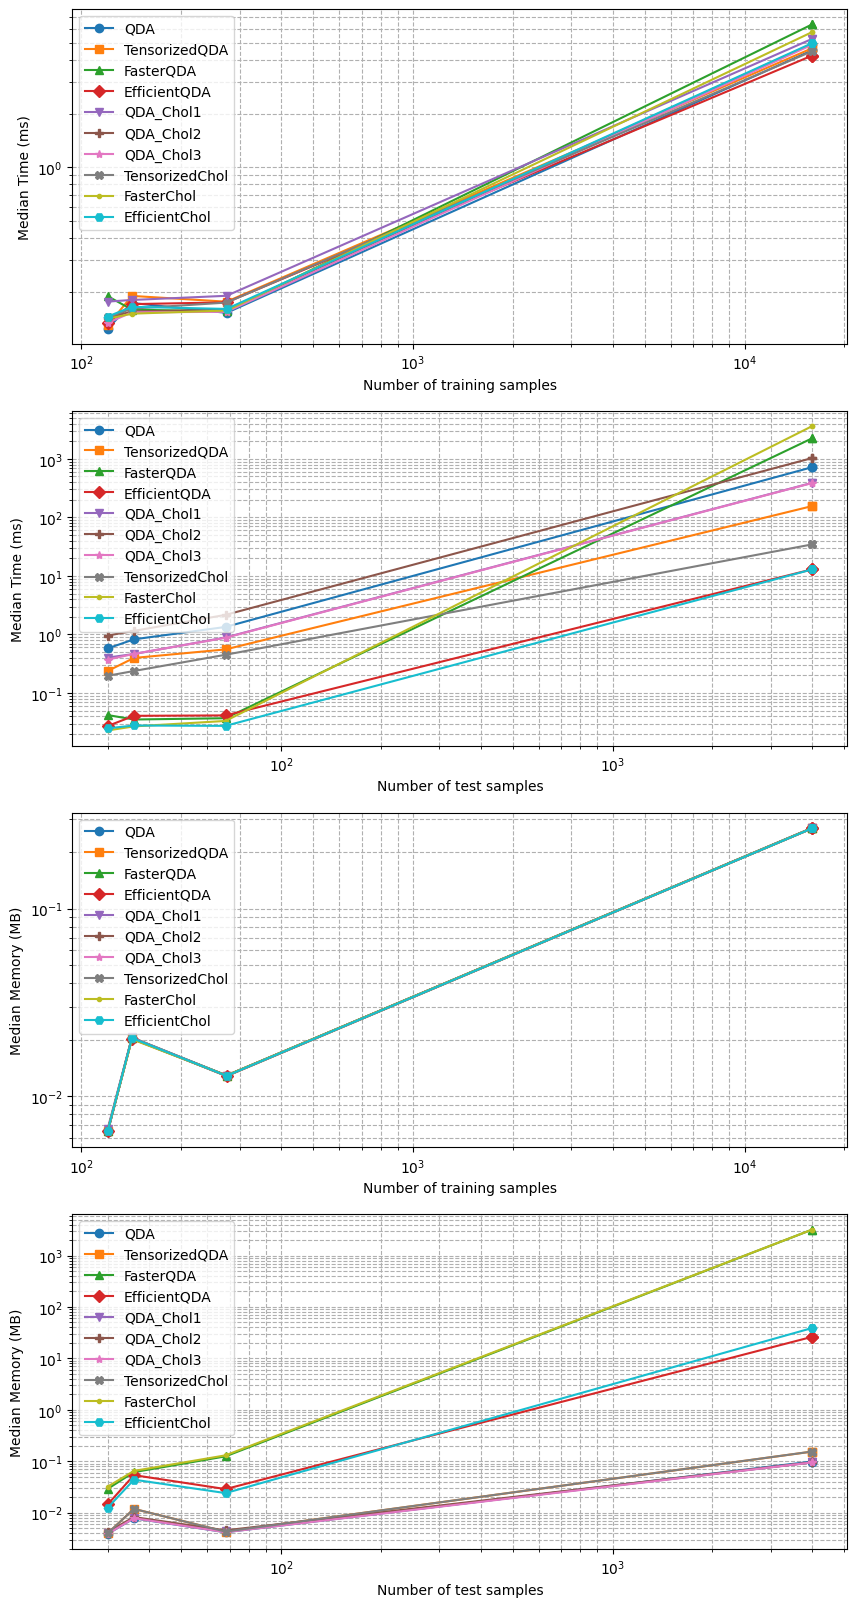

In [41]:
benchs.append(b)
for b_i in benchs:
    b_i.get_results_dict()
import matplotlib.pyplot as plt

# Plot median times vs sizes for training
labels = ["QDA", "TensorizedQDA", "FasterQDA", "EfficientQDA",
          "QDA_Chol1", "QDA_Chol2", "QDA_Chol3",
          "TensorizedChol", "FasterChol", "EfficientChol"]
markers = ['o', 's', '^', 'D', 'v', 'P', '*', 'X', '.', 'H']
train_sizes = []
test_sizes = []
train_median_ms = [[] for i in range(len(b_i.results_dict['train_median_ms']))]
test_median_ms = [[] for i in range(len(b_i.results_dict['test_median_ms']))]
train_median_mb = [[] for i in range(len(b_i.results_dict['train_median_mb']))]
test_median_mb = [[] for i in range(len(b_i.results_dict['test_median_mb']))]
for b_i in benchs:
    train_sizes.append(b_i.results_dict['train_size'])
    test_sizes.append(b_i.results_dict['test_size'])
    for i, label in enumerate(labels):
        train_median_ms[i].append(b_i.results_dict['train_median_ms'][label])
        test_median_ms[i].append(b_i.results_dict['test_median_ms'][label])
        train_median_mb[i].append(b_i.results_dict['train_median_mb'][label])
        test_median_mb[i].append(b_i.results_dict['test_median_mb'][label])

fig, axs = plt.subplots(4,1, figsize=(10, 20))

for i, label in enumerate(labels):
    axs[0].plot(train_sizes, train_median_ms[i], marker=markers[i], label=label)
    axs[1].plot(test_sizes, test_median_ms[i], marker=  markers[i], label=label)
    axs[2].plot(train_sizes, train_median_mb[i], marker=markers[i], label=label)
    axs[3].plot(test_sizes, test_median_mb[i], marker=  markers[i], label=label)

for i in range(4):
    axs[i].set_yscale('log')
    axs[i].set_xscale('log')
    axs[i].legend()
    axs[i].grid(True, which="both", ls="--")
    axs[i].set_ylabel('Median Time (ms)' if i in [0,1] else 'Median Memory (MB)')
    axs[i].set_xlabel('Number of training samples' if i in [0,2] else 'Number of test samples')
plt.show()